In [1]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.scalar_mediator import ScalarMediator
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import (egret_diffuse,
                                                               fermi_diffuse,
                                                               comptel_diffuse,
                                                               gc_bg_model_target,
                                                               gc_bg_model)

colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

In [2]:
gsxx = 1.0
gsff = 1.0
gsGG = 1.0
gsFF = 1.0
ms = 1.0

# vx_mw = 1.0e-3 # DM velocity in Milky Way halo
# def ex(mx, vx=vx_mw):
#     return mx + 0.5 * mx * vx**2

## Set up Higgs portal model

In [3]:
s_theta = 0.5
sm_hp = ScalarMediator(mx=1., ms=ms, gsxx=1.0, gsff=s_theta, gsGG=s_theta, gsFF=-s_theta)

# Masses to scan over
mx_min = 0.55
mx_max = 3000.
n_mxs = 50
mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)

## Recompute limits

In [9]:
lims_egret = sm_hp.binned_limits(mxs, egret_diffuse)
lims_comptel = sm_hp.binned_limits(mxs, comptel_diffuse)
lims_fermi = sm_hp.binned_limits(mxs, fermi_diffuse)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/hazma/gamma_ray_limits/compute_limits.py:211: RuntimeWarning: divide by zero encountered in double_scalars
  sv_lims.append(phi_max / phi_dm)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: Integr

In [9]:
lims_e_astrogam = sm_hp.unbinned_limits(mxs, target_params=gc_bg_model_target, bg_model=gc_bg_model)

e_a: 0.061645 -> 0.061645
e_b: 0.184936 -> 0.184936
 


KeyboardInterrupt: 

## Load previously compute limits

In [4]:
lims_egret = np.loadtxt("data/lims_egret.csv", delimiter=",")
lims_comptel = np.loadtxt("data/lims_comptel.csv", delimiter=",")
lims_fermi = np.loadtxt("data/lims_fermi.csv", delimiter=",")
lims_e_astrogam = np.loadtxt("data/lims_e_astrogam.csv", delimiter=",")

## Galactic Center constraints

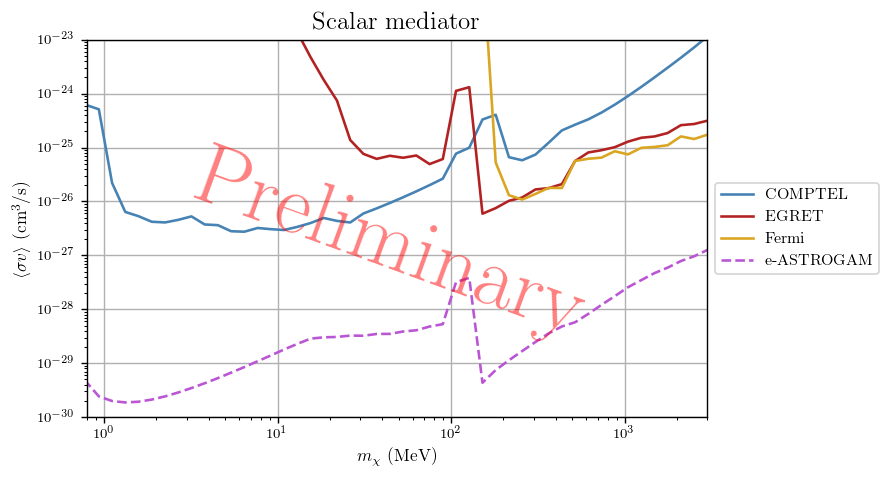

In [5]:
plt.figure(figsize=(8, 4))

plt.plot(mxs, lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(mxs, lims_egret, label="EGRET", color=colors[1])
plt.plot(mxs, lims_fermi, label="Fermi", color=colors[2])
plt.plot(mxs, lims_e_astrogam, '--', label="e-ASTROGAM", color=colors[3])

plt.xlim([0.8, mxs[-1]])
plt.ylim([1e-30,1e-23])
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title("Scalar mediator")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.text(3, 1e-26, 'Preliminary', fontsize=50, color='red', alpha=0.5, rotation=-20)
plt.savefig("figures/sigmav_limits.pdf")

In [13]:
import os
os.system("printf '\a'")

0